In [1]:
import sys
import os
import numpy as np
import torch
import yaml
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

# Add the path to the parent directory of subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

# Now you can import your_module from subfolder
from src import data_processing, data_ingesting, utils, evaluation
from models.discharge import model_discharge

def set_seed(seed):
    """
    Set the seed for generating random numbers.

    Args:
        seed (int): The seed value to use.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # for reproducibility
    torch.backends.cudnn.benchmark = False  # for reproducibility

# set seed
set_seed(18)

gpu_idx = 0
device = torch.device(f"cuda:{gpu_idx}") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [2]:
path_dataset = r'C:\Users\62812\Documents\Kerjaan Meteorologi\FEWS BNPB\Code\github\EWS of Flood Forecast\data\raw\ML 1\Hidrologi Palu 2016-2024.xlsx'
data = pd.read_excel(path_dataset)

In [3]:
#Drop the first two month data. total two months data is 2 * 30 * 24 = 1440. Ask yogi why.
col_to_drop_for_x = ['No', 'Date', 'Miu', 'Kualakuning', 'Tuvanjuka', 'Palu', 'Observasi']
target = 'Miu'
X = data.drop(columns = col_to_drop_for_x).to_numpy()[1440:]
y = data['Miu'].values[1440:]
dates = data['Date'][1440:]

In [4]:
#seperate train and val dataset
train_dist = 0.8 #set train for dataset
len_train = int(train_dist * len(X))

X_train, y_train  = X[0:len_train], y[0:len_train]
date_train = dates[0:len_train]
date_val = dates[len_train:]

X_val, y_val = X[len_train:] , y[len_train:]

In [5]:
print(X_train.shape,y_train.shape, X_val.shape, y_val.shape)

(54932, 114) (54932,) (13733, 114) (13733,)


In [6]:
def create_input_output(X, y, dates, len_input, len_target):
    forecast_len = len_target - len_input
    X_dataset = []
    y_dataset = []
    date_x_dataset = []
    date_y_dataset = []
    total_dataset = len(X) - max(len_input, len_target)
    prec_at_forecasat_hour = []
    for i in range(total_dataset):
        x_forecast = X[i:i+len_target][-forecast_len:]
        prec_at_forecasat_hour.append(x_forecast)
        x_i = X[i:i+len_input]
        y_i = y[i:i+len_target]
        date_xi = dates[i:i+len_input]
        date_yi = dates[i:i+len_target]
        X_dataset.append(x_i); y_dataset.append(y_i)
        date_x_dataset.append(date_xi); date_y_dataset.append(date_yi) 
    return np.array(X_dataset), np.array(y_dataset), np.array(date_x_dataset), np.array(date_y_dataset), np.array(prec_at_forecasat_hour)

def filter_dataset_using_threshold_prec(X, y, prec_at_forecast_hour, th, p = None, mode = "lt"):
    """
    Function to filter dataset using the threshold with percentil or value of precipitation
    Args:
        X: All input data
        y: All target data
    Returns:
        X: filtered input data using threshold
        y: filtered target data using threshold
    """
    mean_prec = np.mean(prec_at_forecast_hour, axis = (1,2))
    if p and mode == "lt":
        th = np.percentile(mean_prec, p)
        idx_chosen= np.where(mean_prec < th)
    elif p and mode == "gt":
        th = np.percentile(mean_prec, p)
        idx_chosen= np.where(mean_prec > th)
    else:
        if mode == "lt":
            idx_chosen = np.where(mean_prec < th)
        elif mode == "gt":
            idx_chosen = np.where(mean_prec> th)
    return X[idx_chosen], y[idx_chosen]

In [7]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((54932, 114), (13733, 114), (54932,), (13733,))

In [8]:
len_input = 6 * 24
len_target = len_input + 24

X_train_dataset, y_train_dataset, date_train_x_dataset, date_train_y_dataset, prec_at_forecast_hour_train = create_input_output(X=X_train, y=y_train, dates=date_train,
                                                                             len_input=len_input, len_target=len_target)

X_val_dataset, y_val_dataset, date_val_x_dataset, date_val_y_dataset, prec_at_forecast_hour_val = create_input_output(X=X_val, y=y_val, dates=date_val,
                                                                             len_input=len_input, len_target=len_target)

In [9]:
X_train_dataset.shape, X_val_dataset.shape, y_train_dataset.shape, y_val_dataset.shape, prec_at_forecast_hour_train.shape, prec_at_forecast_hour_val.shape

((54764, 144, 114),
 (13565, 144, 114),
 (54764, 168),
 (13565, 168),
 (54764, 24, 114),
 (13565, 24, 114))

#### Visualize Data input Output

In [10]:
filter_dataset = False
if filter_dataset == True:
    p = 25 #percentile 
    mode = "lt" # lt or gt. lt means less than, gt means greater than
    th = 0 #threshold of a precipitation, if we have specific threshold then we just need to define it here (set value of P to None), otherwise use P
    
    X_train_dataset, y_train_dataset  = filter_dataset_using_threshold_prec(X = X_train_dataset, y= y_train_dataset,
                                                          prec_at_forecast_hour = prec_at_forecast_hour_train,
                                                          th = th, p = p, mode = mode)
    
    X_val_dataset, y_val_dataset  = filter_dataset_using_threshold_prec(X = X_val_dataset, y= y_val_dataset,
                                                          prec_at_forecast_hour = prec_at_forecast_hour_val,
                                                          th = th, p = p, mode = mode)
    print("Filtering dataset DONE")

In [11]:
#get the shape and what it means
number_of_samples_train, length_of_seq_input, number_of_basins = X_train_dataset.shape
number_of_samples_val = len(X_val_dataset)

print("Dataset shape before flatten")
print(X_train_dataset.shape, X_val_dataset.shape, y_train_dataset.shape, y_val_dataset.shape)

#flatten the subbasin
X_train_dataset = X_train_dataset.reshape(number_of_samples_train, length_of_seq_input * number_of_basins)
X_val_dataset = X_val_dataset.reshape(number_of_samples_val,length_of_seq_input * number_of_basins)
print("Dataset shape After flatten")
print(X_train_dataset.shape, X_val_dataset.shape, y_train_dataset.shape, y_val_dataset.shape)

Dataset shape before flatten
(54764, 144, 114) (13565, 144, 114) (54764, 168) (13565, 168)
Dataset shape After flatten
(54764, 16416) (13565, 16416) (54764, 168) (13565, 168)


#### Data Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def standard_scaler_normalization(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return scaler, normalized_data

def min_max_normalization(data):
    # Min-Max Scaling
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    return scaler, normalized_data

def normalize_data(data, method):
    if method == "standard scaler":
        scaler, normalized_data = standard_scaler_normalization(data)
    elif method == "min max scaler":
        scaler, normalized_data = min_max_normalization(data)
    return scaler, normalized_data

list_of_normalize_method = ["standard scaler", "min max scaler"]
idx_method = 0
do_normalize = False
if do_normalize:
    method = list_of_normalize_method[idx_method]
    scaler_train, X_train_dataset = normalize_data(data= X_train_dataset, method = method)
    scaler_val, X_val_dataset = normalize_data(data = X_val_dataset, method = method)

### Data Visualization

In [13]:
# def plot_ch_debit(data_debit, data_ch, date_debit, date_ch, title, path, save = False):
    
#     # Initialize the plot with a specified figure size
#     fig, ax1 = plt.subplots(figsize=(8, 5))

#     # Plotting y2 with ax1
#     ax1.plot(date_debit, data_debit, 'b-', label = "debit")  # 'b-' sets the line color to blue
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel('Debit (m3/hr)', color='b')  # Setting the label color to match the line color
#     ax1.tick_params(axis='y', labelcolor='b')
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=25)  # Rotate labels by 45 degrees
    
#     # Creating a twin of the ax1 for y1 with separate y-axis
#     ax2 = ax1.twinx()
#     ax2.plot(date_ch, data_ch, 'r-', label = "precip")  # 'r-' sets the line color to red
#     ax2.set_ylabel('precip (mm/hr)', color='r')  # Setting the label color to match the line color
#     ax2.tick_params(axis='y', labelcolor='r')
    
#     # Show the plot
#     plt.title(title)
#     plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
#     if save:
#         fig.savefig(f"{path}/{title}.png")
#     plt.show()

In [14]:
# path = "image/Exercise 3"
# for i in range(5):
#     n = np.random.randint(0,len(X_input))
#     data_ch = X_input[n]
#     data_debit = y_train_dataset[n]
#     date_debit = date_train_dataset[n]
#     title = f"Sample {n} Input and Output Dataset"
#     plot_ch_debit(data_debit, data_ch, date_debit, date_debit, title, path, save = True)

### BUILD MODEL 

In [15]:
# # Define a basic ResNet block
# class BasicBlock(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(BasicBlock, self).__init__()
#         self.fc1 = nn.Linear(in_features, out_features)
#         self.bn1 = nn.BatchNorm1d(out_features)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(out_features, out_features)
#         self.bn2 = nn.BatchNorm1d(out_features)
        
#         # Shortcut connection
#         if in_features != out_features:
#             self.shortcut = nn.Sequential(
#                 nn.Linear(in_features, out_features),
#                 nn.BatchNorm1d(out_features)
#             )
#         else:
#             self.shortcut = nn.Identity()
    
#     def forward(self, x):
#         identity = x
#         out = self.fc1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.bn2(out)
        
#         identity = self.shortcut(identity)
#         out += identity
#         out = self.relu(out)
#         return out

# # Define the main model
# class RegressionModelWithResNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(RegressionModelWithResNet, self).__init__()
#         # Initial fully connected layer
#         self.fc_input = nn.Linear(input_size, 128)  # Reduce dimensionality before ResNet block
        
#         # ResNet block
#         self.resnet_block = BasicBlock(128, 128)
        
#         # Output layer
#         self.fc_output = nn.Linear(128, output_size)
    
#     def forward(self, x):
#         x = self.fc_input(x)
#         x = self.resnet_block(x)
#         x = self.fc_output(x)
#         return x

# # create model regression 
# def create_model_fc_resnet(input_size, output_size):
#     model = RegressionModelWithResNet(input_size=input_size, output_size=output_size)
#     return model

In [16]:
# Define a basic ResNet block with dropout
class BasicBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(BasicBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.bn1 = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(p=dropout_prob)  # Add dropout layer
        
        # Shortcut connection
        if in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        identity = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after ReLU
        
        out = self.fc2(out)
        out = self.bn2(out)
        
        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)
        return out

# Define the main model with dropout
class RegressionModelWithResNet(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.2):
        super(RegressionModelWithResNet, self).__init__()
        # Initial fully connected layer
        self.fc_input = nn.Linear(input_size, 64)  # Reduce dimensionality before ResNet block
        
        # ResNet block with dropout
        self.resnet_block = BasicBlock(64, 64, dropout_prob=dropout_prob)
        
        # Output layer
        self.fc_output = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(p=dropout_prob)  # Add dropout before output if desired
    
    def forward(self, x):
        x = self.fc_input(x)
        x = self.resnet_block(x)
        x = self.dropout(x)  # Apply dropout before output
        x = self.fc_output(x)
        return x

# Create model with dropout
def create_model_fc_resnet(input_size, output_size, dropout_prob=0.5):
    model = RegressionModelWithResNet(input_size=input_size, output_size=output_size, dropout_prob=dropout_prob)
    return model

In [17]:
def train_model(model, criterion, optimizer, train_loader, device, num_epoch):
    model.train()  # Set model to training mode
    
    for epoch in range(1):
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {num_epoch+1}, Loss: {epoch_loss:.4f}')
    return epoch_loss

def validate_model(model, criterion, val_loader, device):
    model.eval()  # Set model to evaluate mode
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    
    average_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {average_loss:.4f}')
    return average_loss,outputs

In [18]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloader(X, y, batch_size, shuffle=False):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [19]:
#preprocess data input
X_train_input = torch.tensor(X_train_dataset, dtype = torch.float32)
X_val_input = torch.tensor(X_val_dataset, dtype = torch.float32)

y_train_dataset = torch.tensor(y_train_dataset, dtype = torch.float32)
y_val_dataset = torch.tensor(y_val_dataset, dtype = torch.float32)

In [20]:
X_train_input.shape, X_val_input.shape, y_train_dataset.shape, y_val_dataset.shape

(torch.Size([54764, 16416]),
 torch.Size([13565, 16416]),
 torch.Size([54764, 168]),
 torch.Size([13565, 168]))

In [21]:
# Data loaders
batch_size = 32

train_loader = create_dataloader(X=X_train_input, y=y_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = create_dataloader(X=X_val_input, y=y_val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, criterion, and optimizer
input_size = X_train_input.shape[1]
output_size = y_train_dataset.shape[1]

#model = FullyConnectedModel(input_size, output_size)
model = create_model_fc_resnet(input_size=input_size, output_size=output_size)
model.to(device)

RegressionModelWithResNet(
  (fc_input): Linear(in_features=16416, out_features=64, bias=True)
  (resnet_block): BasicBlock(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (shortcut): Identity()
  )
  (fc_output): Linear(in_features=64, out_features=168, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
%%time
criterion = nn.MSELoss()  # Assuming a regression task
# Define RMSProp optimizer
#optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
num_epochs = 50
curr_loss = 9999999999
train_loss, val_loss = [],[]
for epoch in range(num_epochs):
    epoch_loss = train_model(model, criterion, optimizer, train_loader,device, num_epoch=epoch)
    avg_loss, outputs = validate_model(model, criterion, val_loader, device)
    train_loss.append(epoch_loss)
    val_loss.append(avg_loss)
    if avg_loss < curr_loss:
        torch.save(model.state_dict(), f'Ml 1 best at epoch {epoch}.pth')
        curr_loss = avg_loss

Epoch 1, Loss: 6572.8968
Validation Loss: 4651.7778
Epoch 2, Loss: 5679.8697
Validation Loss: 4366.9117
Epoch 3, Loss: 5400.5277
Validation Loss: 4295.5513
Epoch 4, Loss: 5216.6142
Validation Loss: 4280.2569
Epoch 5, Loss: 5090.7881
Validation Loss: 4275.0371
Epoch 6, Loss: 4949.5325
Validation Loss: 4332.7420
Epoch 7, Loss: 4897.3681
Validation Loss: 4311.8578
Epoch 8, Loss: 4788.4965
Validation Loss: 4319.6997
Epoch 9, Loss: 4718.0294
Validation Loss: 4291.2249
Epoch 10, Loss: 4643.5827
Validation Loss: 4350.2752
Epoch 11, Loss: 4593.4899
Validation Loss: 4495.0418
Epoch 12, Loss: 4524.7498
Validation Loss: 4343.5447
Epoch 13, Loss: 4462.5176
Validation Loss: 4479.9757
Epoch 14, Loss: 4453.9269
Validation Loss: 4413.2158
Epoch 15, Loss: 4395.1093
Validation Loss: 4514.6896
Epoch 16, Loss: 4345.0243
Validation Loss: 4582.2959
Epoch 17, Loss: 4308.9526
Validation Loss: 4511.7358
Epoch 18, Loss: 4294.3022
Validation Loss: 4496.5967
Epoch 19, Loss: 4244.7567
Validation Loss: 4499.3320
Ep

In [36]:
# # # Save only the model's state_dict (recommended approach)
# torch.save(model.state_dict(), 'Ml 1 with filtering prec.pth')

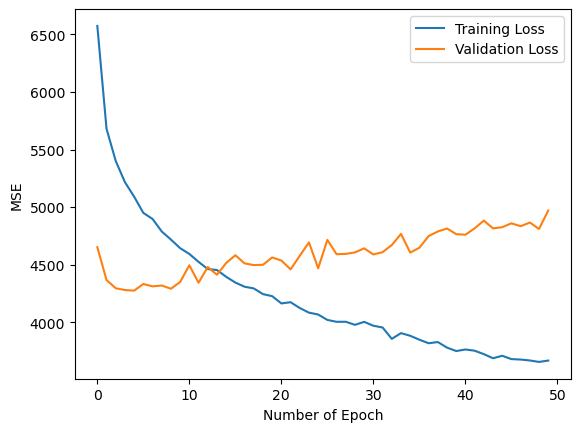

In [24]:
plt.plot(train_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.xlabel("Number of Epoch")
plt.ylabel("MSE")
plt.legend()
plt.savefig("image/Final/Train and Validation of MSE error.png")
plt.show()

In [29]:
X_val_input

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [30]:
with torch.no_grad():
    outputs = model(X_val_input.to(device))
    outputs = outputs.cpu().numpy()

In [35]:
n

9336

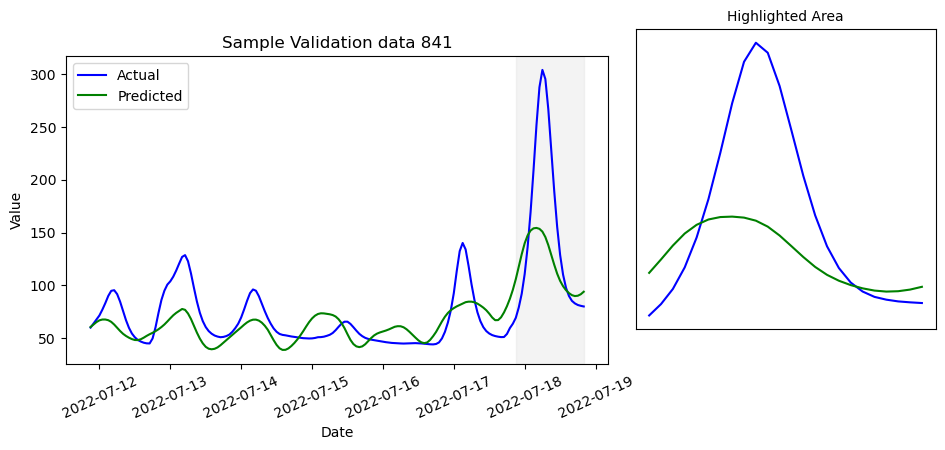

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generate some example time series data
n = np.random.randint(0,len(X_val_input))
n = 841
y_pred = outputs[n]
y_real = y_val_dataset[n]

dates = date_val_y_dataset[n]

# Plot the entire time series data
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(dates, y_real, label='Actual', color='blue')
ax.plot(dates, y_pred, label='Predicted', color='green')

# Rotate the x-ticks
plt.xticks(rotation=25)

# Highlight the vertical area for the last 24 data points
ax.axvspan(dates[-24], dates[-1], color='lightgray', alpha=0.25)

# Create an inset plot (mini-plot) outside the original axes box
# Position the inset using `bbox_to_anchor` and `loc`
ax_inset = inset_axes(ax, width=3, height=3,  # Use absolute units like inches
                      bbox_to_anchor=(1.05, 0.5, 0.2, 0.2),  # 4-tuple to define the position
                      bbox_transform=ax.transAxes, loc='center left', borderpad=0)

ax_inset.plot(dates[-24:], y_real[-24:], color='blue', linestyle='-', markersize=4)
ax_inset.plot(dates[-24:], y_pred[-24:], color='green', linestyle='-', markersize=4)
ax_inset.set_title('Highlighted Area', fontsize=10)
ax_inset.set_xticks([])  # Optionally remove x-ticks
ax_inset.set_yticks([])  # Optionally remove y-ticks

# Add labels and title to the main plot
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title(f"Sample Validation data {n}")

# Move the legend to the top-left corner for both the main plot and the inset
ax.legend(loc='upper left')
#ax_inset.legend(loc='upper left')

plt.savefig(f"image/Final/Sample {n} inference FCResNet all data.png",bbox_inches='tight')
# Show the plot
plt.show()

In [58]:
def calc_rmse_at_each_samples(actual, predicted):
    """
    Function to calculate the rmse of the validation data
    Args:
        actual: array like, ground truth data
        predicted: array like, predicted data from the model
    returns:
        all_rmse: all the rmse value from each samples of cases
    """
    all_rmse = []
    for i in range(len(actual)):
        all_rmse.append(np.sqrt(np.mean((actual[i] - predicted[i]) ** 2)))
    return np.array(all_rmse)

In [59]:
import numpy as np
y_val_dataset = y_val_dataset.numpy()

rmse_each_samples_all = calc_rmse_at_each_samples(y_val_dataset, outputs)

rmse_each_samples_forecasted =  calc_rmse_at_each_samples(y_val_dataset[:,-24:], outputs[:,-24:])
                                              
# Calculate RMSE all data
rmse_all = np.sqrt(np.mean((y_val_dataset- outputs) ** 2))

# Calculate forecast RMSE
rmse_forecast = np.sqrt(np.mean((y_val_dataset[:,-24:] - outputs[:,-24:]) ** 2))

#calculate estimated RMSE
rmse_estimated = np.sqrt(np.mean((y_val_dataset[:,:-24] - outputs[:,:-24]) ** 2))

print(f"RMSE all: {rmse_all}, RMSE Estimated: {rmse_estimated}, RMSE forecasted: {rmse_forecast}")

RMSE all: 70.49935150146484, RMSE Estimated: 71.11137390136719, RMSE forecasted: 66.70951843261719


In [60]:
def calculate_corr(predicted, real):
    """
    Function to calculate correlation of all cases in data validation
    Args:
        predicted: predicted value of debit
        real: ground truth value of debit
    Returns:
        all_corr: list of correlation between the predicted and real in all cases

    """
    t,x = predicted.shape
    all_corr = []
    for i in range(t):  
        # Calculate Pearson correlation coefficient
        correlation = np.corrcoef(predicted[i], real[i])[0, 1]
        all_corr.append(correlation)
    return all_corr

In [61]:
corr_all = calculate_corr(y_val_dataset, outputs)
corr_forcasted = calculate_corr(y_val_dataset[:,-24:],outputs[:,-24:])
corr_estimated = calculate_corr(y_val_dataset[:,:-24],outputs[:,:-24])

In [62]:
print(f"Corr all: {np.mean(corr_all)}, Corr Estimated: {np.mean(corr_estimated)}, Corr forecasted: {np.mean(corr_forcasted)}")

Corr all: 0.625567747614508, Corr Estimated: 0.6537772450833117, Corr forecasted: 0.24051965101677142


#### Visualisasi Error Validasi dan Analisis Error

In [63]:
p5 = np.percentile(rmse_each_samples_forecasted, 5)
p95 = np.percentile(rmse_each_samples_forecasted, 95)

idx_lt_p5 = np.where(rmse_each_samples_forecasted < p5)
idx_gt_p95  = np.where(rmse_each_samples_forecasted > p95)

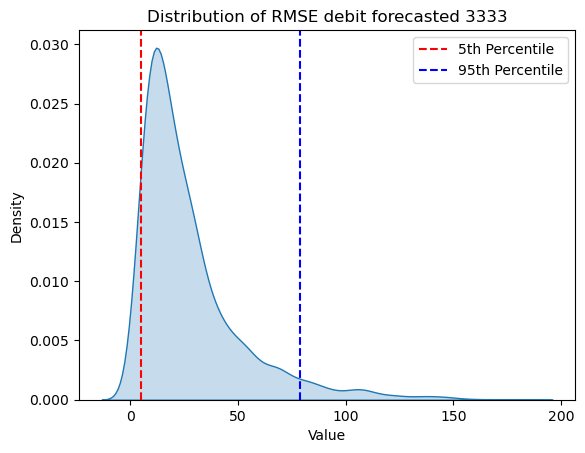

In [101]:
import seaborn as sns
number_of_cases = len(rmse_each_samples_forecasted)
sns.kdeplot(rmse_each_samples_forecasted, fill=True)  # shade=True to fill the area under the curve
# Add vertical lines at the 10th and 90th percentiles
plt.axvline(p5, color='red', linestyle='--', label='5th Percentile')
plt.axvline(p95, color='blue', linestyle='--', label='95th Percentile')
plt.title(f'Distribution of RMSE debit forecasted {number_of_cases}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.savefig("Distribution of RMSE debit forecasted.png", bbox_inches = "tight")
plt.show()

In [84]:
prec_at_forecasted_idx_lt_p5 = prec_at_forecast_hour_val[idx_lt_p5]
prec_at_forecasted_idx_gt_p95 = prec_at_forecast_hour_val[idx_gt_p95]

mean_prec_at_forecasted_idx_lt_p5 = np.mean(prec_at_forecasted_idx_lt_p5, axis = (1,2))
sum_prec_at_forecasted_idx_lt_p5 = np.sum(prec_at_forecasted_idx_lt_p5, axis = (1,2))

mean_prec_at_forecasted_idx_gt_p95 = np.mean(prec_at_forecasted_idx_gt_p95, axis = (1,2))
sum_prec_at_forecasted_idx_gt_p95 = np.sum(prec_at_forecasted_idx_gt_p95, axis = (1,2))

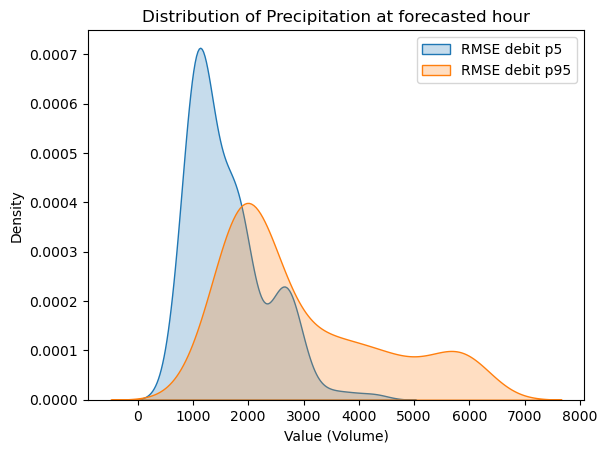

In [99]:
import seaborn as sns
number_of_cases = len(mean_prec_at_forecasted_idx_lt_p5)
n_p5 = len(sum_prec_at_forecasted_idx_lt_p5)
n_p95 = len(sum_prec_at_forecasted_idx_gt_p95)

sns.kdeplot(sum_prec_at_forecasted_idx_lt_p5, fill=True, label = f"RMSE debit p5")  # shade=True to fill the area under the curve
sns.kdeplot(sum_prec_at_forecasted_idx_gt_p95, fill=True, label = f"RMSE debit p95")
# Add vertical lines at the 10th and 90th percentiles
plt.title(f'Distribution of Precipitation at forecasted hour')
plt.xlabel('Value (Volume)')
plt.ylabel('Density')
plt.legend()
plt.savefig("Distribution of Precipitation at forecasted hour.png", bbox_inches = "tight")
plt.show()

### Tambahan Model untuk Forecast (Seq2Seq)

In [ ]:
def create_dataset_lstm_from_predicted_fc(data_predicted, len_input_seq):
    assert len(data_predicted.shape) == 2, "Input must have 2 dimension"
    n,t = data_predicted.shape
    output_dataset = set()
    l = t - len_input_seq - 1# l is the number of data we can create from 168 data sequence
    for i in range(n):
        for j in range(l-1):
            xij = data_predicted[i][j:len_input_seq+j]
            yij = data_predicted[i][len_input_seq+j+1]
            data_ij = (tuple(xij), yij)
            if data_ij not in output_dataset:
                output_dataset.add(data_ij)
    return output_dataset

In [ ]:
output_dataset = create_dataset_lstm_from_predicted_fc(data_predicted=outputs_train, len_input_seq=len_input)
trains_y_dataset = create_dataset_lstm_from_predicted_fc(data_predicted=y_train_dataset, len_input_seq=len_input)

In [8]:
X_train_input.shape, X_val_input.shape, y_train_dataset.shape, y_val_dataset.shape

NameError: name 'X_train_input' is not defined

In [30]:
def create_lstm_dataset(data, input_sequence_len, target_sequence_len):
    """
    Prepare time series data for LSTM model with variable input and target sequence lengths.

    Parameters:
    data (np.ndarray or list): The time series data.
    input_sequence_len (int): The number of time steps in each input sequence.
    target_sequence_len (int): The number of time steps in each target sequence.

    Returns:
    np.ndarray: Array containing the input sequences.
    np.ndarray: Array containing the target sequences.
    """
    data = np.array(data)
    X, y = [], []
    for i in range(len(data) - input_sequence_len - target_sequence_len + 1):
        X.append(data[i:i + input_sequence_len])
        y.append(data[i + input_sequence_len:i + input_sequence_len + target_sequence_len])

    X,y = np.array(X), np.array(y)
    # Convert NumPy array to PyTorch tensor
    X = torch.tensor(X, dtype=torch.float32)
    X = X.unsqueeze(-1)  # Adds a dimension at the last position
    
    # Convert NumPy array to PyTorch tensor
    y = torch.tensor(y, dtype=torch.float32)
    y = y.unsqueeze(-1)  # Adds a dimension at the last position

    return X,y

In [31]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(EncoderLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_seq.device)
        _, (hidden, cell) = self.lstm(input_seq, (h0, c0))
        return hidden, cell

# Define the Decoder LSTM
class DecoderLSTM(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1, dropout=0.0):
        super(DecoderLSTM, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, decoder_input, hidden, cell, target_seq_len):
        outputs = []
        for _ in range(target_seq_len):
            output, (hidden, cell) = self.lstm(decoder_input, (hidden, cell))
            output = self.fc(output)
            outputs.append(output)
            decoder_input = output
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Define the Seq2Seq model
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = EncoderLSTM(input_size, hidden_size, num_layers, dropout)
        self.decoder = DecoderLSTM(output_size, hidden_size, num_layers, dropout)

    def forward(self, input_seq, target_seq_len):
        hidden, cell = self.encoder(input_seq)
        batch_size = input_seq.size(0)
        decoder_input = torch.zeros(batch_size, 1, 1).to(input_seq.device)
        outputs = self.decoder(decoder_input, hidden, cell, target_seq_len)
        return outputs

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, target_seq_len, device):
    model.train()
    train_losses, val_losses = [],[] 
    for epoch in range(num_epochs):
        epoch_loss = 0
        for input_seq, target_seq in train_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            optimizer.zero_grad()
            output_seq = model(input_seq, target_seq_len)
            loss = criterion(output_seq, target_seq)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        _,_,val_loss = evaluate(model, val_loader, criterion, target_seq_len, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
    return train_losses, val_losses

# Evaluation function
def evaluate(model, test_loader, criterion, target_seq_len, device):
    model.eval()
    epoch_loss = 0
    all_actuals = []
    all_predictions = []
    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output_seq = model(input_seq, target_seq_len)
            loss = criterion(output_seq, target_seq)
            epoch_loss += loss.item()
            all_actuals.append(target_seq.cpu().numpy())
            all_predictions.append(output_seq.cpu().numpy())
    avg_loss = epoch_loss / len(test_loader)
    #print(f'Test Loss: {avg_loss:.4f}')
    model.train()
    return np.concatenate(all_actuals, axis=0), np.concatenate(all_predictions, axis=0), avg_loss

In [32]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloader(X, y, batch_size, shuffle=False):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [93]:
input_sequence_len = len_input
target_sequence_len  = 24
batch_size = 64
X_lstm_train, y_lstm_train = create_lstm_dataset(data = y_train, 
                                                 input_sequence_len=input_sequence_len,
                                                 target_sequence_len=target_sequence_len)

X_lstm_val, y_lstm_val = create_lstm_dataset(data = y_val, 
                                                 input_sequence_len=input_sequence_len,
                                                 target_sequence_len=target_sequence_len)

data_loader = create_dataloader(X=X_lstm_train, y = y_lstm_train, batch_size= batch_size, shuffle = True)
val_loader = create_dataloader(X=X_lstm_val, y = y_lstm_val, batch_size= batch_size, shuffle = False)

In [87]:
# # Hyperparameters
# input_dim = 1  # Assuming the data is univariate
# output_dim = 1
# hidden_dim = 64
# num_layers = 2
# dropout = 0.2
# learning_rate = 0.001
# num_epochs = 40
# batch_size = 64

# data_loader = create_dataloader(X_lstm_train, y_lstm_train, batch_size, shuffle=True)
# val_loader = create_dataloader(X_lstm_val, y_lstm_val, batch_size, shuffle=False)

# # Model, Loss, Optimizer
# encoder = Encoder(input_dim, hidden_dim, num_layers, dropout)
# decoder = Decoder(output_dim, hidden_dim, num_layers, dropout)
# model = Seq2Seq(encoder, decoder).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for xb, yb in data_loader:
#         xb,yb = xb.to(device), yb.to(device)
        
#         optimizer.zero_grad()
    
#         # Forward pass
#         outputs = model(xb, target_len=24)
        
#         # Compute the loss
#         loss = criterion(outputs, yb)
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
    
#     if (epoch+1) % 5 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [96]:
# Example usage
if __name__ == "__main__":
    input_size = 1
    hidden_size = 128
    output_size = 1
    seq_length = 144
    target_seq_len = 24
    num_layers = 3
    dropout = 0.2

    # Model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Seq2SeqLSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 20
    train_losses, val_losses = train(model, data_loader, val_loader,criterion, optimizer, num_epochs, target_seq_len, device)

    # Evaluate the model
    actuals, predictions, val_loss = evaluate(model, val_loader, criterion, target_seq_len, device)

Epoch [1/20], Train Loss: 10638.7530, Validation Loss: 3132.7176
Epoch [2/20], Train Loss: 5723.4923, Validation Loss: 2017.3176
Epoch [3/20], Train Loss: 4307.3117, Validation Loss: 1241.0571
Epoch [4/20], Train Loss: 3147.6672, Validation Loss: 970.3061
Epoch [5/20], Train Loss: 2632.4249, Validation Loss: 862.9288
Epoch [6/20], Train Loss: 2372.1479, Validation Loss: 842.7823
Epoch [7/20], Train Loss: 2242.0110, Validation Loss: 833.3883
Epoch [8/20], Train Loss: 2137.9240, Validation Loss: 808.8180
Epoch [9/20], Train Loss: 2068.2076, Validation Loss: 820.5946
Epoch [10/20], Train Loss: 1997.6120, Validation Loss: 849.8192
Epoch [11/20], Train Loss: 1962.5667, Validation Loss: 857.7252
Epoch [12/20], Train Loss: 1919.8645, Validation Loss: 839.7669
Epoch [13/20], Train Loss: 1900.6977, Validation Loss: 870.7377
Epoch [14/20], Train Loss: 1889.6703, Validation Loss: 822.1024
Epoch [15/20], Train Loss: 1851.8285, Validation Loss: 834.0702
Epoch [16/20], Train Loss: 1894.8786, Validat

In [101]:
actuals.shape, predictions.shape

((3321, 24, 1), (3321, 24, 1))

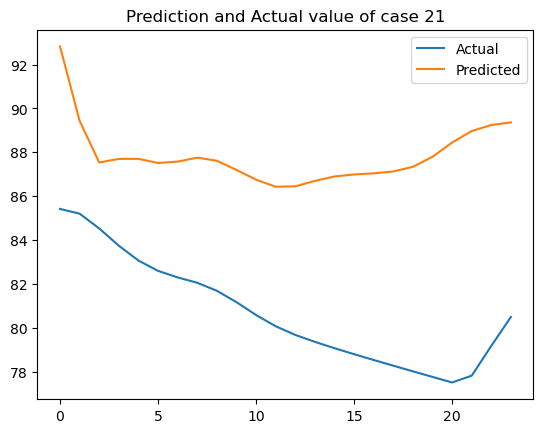

In [114]:
n = np.random.randint(0, len(actuals))
plt.plot(actuals[n,:,0], label = "Actual")
plt.plot(predictions[n,:,0], label = "Predicted")
plt.title(f"Prediction and Actual value of case {n}")
plt.legend()
plt.show()

In [115]:
# Calculate forecast RMSE
rmse_forecast = np.sqrt(np.mean((actuals[:,:,0] - predictions[:,:,0]) ** 2))

In [116]:
rmse_forecast

35.631874

#### Tambahan Model Seq2one

In [205]:
import torch
import torch.nn as nn
import torch.optim as optim

class Seq2One(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(Seq2One, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Only take the last time step's output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [220]:
input_sequence_len = 144
target_sequence_len  = 1
batch_size = 64
X_lstm_train, y_lstm_train = create_lstm_dataset(data = y_train, 
                                                 input_sequence_len=input_sequence_len,
                                                 target_sequence_len=target_sequence_len)

X_lstm_val, y_lstm_val = create_lstm_dataset(data = y_val, 
                                                 input_sequence_len=input_sequence_len,
                                                 target_sequence_len=24)

n,_,_ = y_lstm_train.shape
y_lstm_train = y_lstm_train.view(n,1)

data_loader = create_dataloader(X=X_lstm_train, y = y_lstm_train, batch_size= batch_size, shuffle = True)
val_loader = create_dataloader(X=X_lstm_val, y = y_lstm_val, batch_size= batch_size, shuffle = False)

In [221]:
print(X_lstm_train.shape, y_lstm_train.shape, X_lstm_val.shape, y_lstm_val.shape)

torch.Size([13872, 144, 1]) torch.Size([13872, 1]) torch.Size([3321, 144, 1]) torch.Size([3321, 24, 1])


In [222]:
# Hyperparameters
input_dim = 1  # Assuming the data is univariate
hidden_dim = 64
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 20

# Model, Loss, Optimizer
model = Seq2One(input_dim, hidden_dim, num_layers, dropout).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for xb,yb in data_loader:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(xb)
        
        # Compute the loss
        loss = criterion(outputs, yb)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    losses.append(loss.item())

Epoch [2/20], Loss: 12408.2764
Epoch [4/20], Loss: 6602.3257
Epoch [6/20], Loss: 3657.6199
Epoch [8/20], Loss: 3526.8640
Epoch [10/20], Loss: 1970.3582
Epoch [12/20], Loss: 4159.2354
Epoch [14/20], Loss: 728.3350
Epoch [16/20], Loss: 1576.2773
Epoch [18/20], Loss: 4343.0459
Epoch [20/20], Loss: 1065.7075


In [223]:
def forecast_sequence(model, X_val, len_input_sequence, len_future):
    n,t,input_dim = X_val.shape
    with torch.no_grad():
        outputs = []
        for i in range(n):
            Xi = X_val[i:i+1,:,:].to(device)
            pred = [] #list to contain the value of the output
            for j in range(len_future):
                output = model(Xi[:, -len_input_sequence:, :])
                Xi = torch.cat((Xi, output.unsqueeze(1)), dim = 1)
                pred.append(output.to("cpu").numpy()[0,0])
            outputs.append(pred)
    return outputs

In [224]:
len_future = 24
outputs = forecast_sequence(model = model, X_val = X_lstm_val,
                            len_input_sequence = input_sequence_len, len_future = len_future)

In [225]:
outputs = np.array(outputs)
n,t,indim = y_lstm_val.shape
y_lstm_val = np.reshape(y_lstm_val, (n,-1))

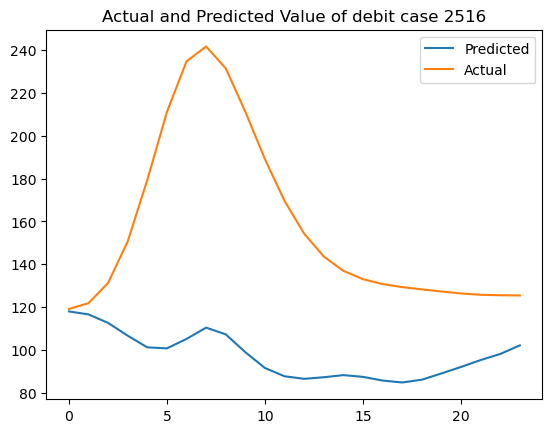

In [228]:
n = np.random.randint(0, len(y_lstm_val))
n = 2516
plt.plot(outputs[n], label = "Predicted")
plt.plot(y_lstm_val[n], label = "Actual")
plt.title(f"Actual and Predicted Value of debit case {n}")
plt.legend()
plt.show()

### Evaluasi output pada kejadian banjir

In [158]:
import numpy as np

# Example data
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Calculate Pearson correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]

print(f"Pearson correlation coefficient: {correlation}")

Pearson correlation coefficient: 0.9999999999999999


In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out, hn, cn

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn, cn))
        out = self.fc(out)
        return out, hn, cn

# Define the Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(hidden_size, output_size, num_layers)
        self.fc = nn.Linear(hidden_size, hidden_size)  # Transform encoder output to decoder input size
        
    def forward(self, x):
        encoder_output, hn, cn = self.encoder(x)
        decoder_input = self.fc(encoder_output[:, -1, :]).unsqueeze(1)
        outputs = []
        for t in range(24):  # Output sequence length is 24
            decoder_output, hn, cn = self.decoder(decoder_input, hn, cn)
            outputs.append(decoder_output)
            decoder_input = decoder_output  # No teacher forcing
        outputs = torch.cat(outputs, dim=1)
        return outputs

# Hyperparameters
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 10
batch_size = 16

# Create synthetic dataset
# Example: input sequences of length 144, output sequences of length 24
X_train = torch.randn(1000, 144, 1)  # 1000 samples, input sequence length 144, 1 feature
y_train = torch.randn(1000, 24, 1)   # 1000 samples, output sequence length 24, 1 feature

X_val = torch.randn(200, 144, 1)     # 200 validation samples
y_val = torch.randn(200, 24, 1)      # 200 validation samples

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 128, got 1

In [33]:
import pickle

# Open the file in read-binary mode
with open('date perkasus.pkl', 'rb') as file:
    # Use pickle.load to deserialize the object from the file
    date_perkasus = pickle.load(file)

In [37]:
for kasus in date_perkasus:
    date_kasus = date_perkasus[kasus]
    for i in range(len(date_val_dataset)):
        if (date_kasus == date_val_dataset[i]).all():
            print(kasus, i)